#  INF8225 Projet QA : HyDE vs RAG-Fusion

##  Import des librairies

In [2]:
import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss
import torch.nn.functional as F
from torch.utils.data import Dataset

import os
import torch
from torch.utils.data import DataLoader
from transformers import AdamW
from tqdm import tqdm


c:\Users\mathi\anaconda3\envs\rag_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Déclarations des constantes

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16

## Chargement des données

In [4]:
root_path = './'
data_path = root_path + 'data/'
questions_test = pd.read_csv(data_path + 'questions_test.csv')
questions_train = pd.read_csv(data_path+'questions_train.csv')
questions_val = pd.read_csv(data_path+'questions_val.csv')
texts = pd.read_csv(data_path + 'texts.csv')

# Colonnes utiles
passages = texts['text'].tolist()
questions_t = questions_test['question'].tolist()
questions_tr = questions_train['question'].tolist()
questions_v = questions_val['question'].tolist()

## Encoding

### Chargement de l'encodeur

In [5]:
from transformers import AutoTokenizer, AutoModel
model_name = 'BAAI/bge-base-en-v1.5'
emb_tokenizer = AutoTokenizer.from_pretrained(model_name)
emb_model = AutoModel.from_pretrained(model_name)
emb_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [6]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "key", "value"],
    lora_dropout=0.05,
    bias="none",
)

emb_model = get_peft_model(emb_model, lora_config)

### Affinage (DPR-Style)

In [7]:
def normalize_tensor(tensor: torch.Tensor) -> torch.Tensor:
    return tensor / torch.norm(tensor, p=2, dim=1, keepdim=True)

def compute_cosine_similarity(a: torch.Tensor, b: torch.Tensor) -> torch.Tensor:
    a_norm, b_norm = normalize_tensor(a), normalize_tensor(b)
    return torch.mm(a_norm, b_norm.T)

def encode_sequences(sequences: list, tokenizer, model, device=DEVICE, batch_size=BATCH_SIZE, training=False) -> torch.Tensor:
    model.train() if training else model.eval()
    context = torch.enable_grad() if training else torch.no_grad()

    embeddings = []
    with context:
        for i in range(0, len(sequences), batch_size):
            batch = sequences[i:i + batch_size]

            # Tokenisation des textes avant entrée du modèle
            inputs = tokenizer(
                batch, padding=True, truncation=True, return_tensors="pt"
            ).to(device)

            # Passage dans le modèle encodeur
            output = model(**inputs).last_hidden_state

            # Pooling : moyenne des vecteurs de tous les tokens pour chaque séquence
            pooled = output.mean(dim=1)  # [batch_size, hidden_size]

            embeddings.append(pooled)

    # Concatène tous les embeddings pour obtenir un seul tensor de sortie
    return torch.cat(embeddings, dim=0)

def retrieve_topk_passages(queries: list, passages: list, tokenizer, model, k: int) -> list[list[int]]:
    # Encode les requêtes (questions)
    query_embeddings = encode_sequences(queries, tokenizer, model)

    # Encode les passages à rechercher
    passage_embeddings = encode_sequences(passages, tokenizer, model)

    # Calcule la similarité cosinus entre chaque question et chaque passage
    similarity = compute_cosine_similarity(query_embeddings, passage_embeddings)

    # Pour chaque question, récupère les indices des k passages les plus similaires
    topk_indices = torch.topk(similarity, k=k, dim=-1).indices.tolist()

    return topk_indices  # Liste de listes d'indices (par question)

In [7]:
class ContrastiveDataset(Dataset):
    """
        Dataset pour l'entraînement du modèle encodeur de type DPR-style.

        Chaque échantillon contient :
        - Une question (query)
        - Un passage pertinent (positive)
        - Une ou plusieurs passages non pertinents (negatives), typiquement des hard negatives

        Le dataset encode les triplets texte en embeddings à chaque appel.
    """
    def __init__(
        self,
        questions: list[str],
        positives: list[str],
        negatives: list[list[str]],
        tokenizer,
        model,
        device=DEVICE,
        is_training=False,
    ):
        # Stockage des données d'entrée
        self.questions = questions
        self.positives = positives
        self.negatives = negatives

        # Configuration
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.training = is_training

    def __len__(self):
        return len(self.questions)

    def encode(self, texts: list[str]) -> torch.Tensor:
        """
        Encode une liste de textes en embeddings
        """
        return encode_sequences(
            texts,
            tokenizer=self.tokenizer,
            model=self.model,
            device=self.device,
            training=self.training
        )

    def __getitem__(self, idx):
        """
        Retourne un triplet :
        - Embedding de la question
        - Embedding du passage positif
        - Embeddings des passages négatifs (sous forme de batch)
        """
        q_text = self.questions[idx]         # Question
        p_text = self.positives[idx]         # Passage pertinent (positif)
        n_texts = self.negatives[idx]        # Liste de passages non pertinents (hard negatives)

        # Encodage
        embeddings = self.encode([q_text, p_text] + n_texts)

        return {
            "question_embedding": embeddings[0],         # [dim]
            "positive_passage_embedding": embeddings[1], # [dim]
            "negative_passage_embedding": embeddings[2:],# [num_neg, dim]
        }

In [8]:
def generate_hard_negative_pairs(questions_df, texts_df, tokenizer, model, max_negatives):
    """
    Génère des triplets (question, passage positif, passages négatifs) 
    pour l'entraînement contrastif (style DPR).

    Les négatifs sont des hard negatives : passages récupérés par similarité
    mais qui ne sont pas des passages pertinents.
    """

    # Listes finales contenant les triplets textuels
    questions_string, positives_string, negatives_string = [], [], []

    # Mapping rapide passage_id → texte
    id_to_text = dict(zip(texts_df['id'], texts_df['text']))
    # Liste complète des textes
    all_passages = texts_df['text'].tolist()

    # Extraction des passages positifs pour chaque question
    ground_truth_ids = questions_df['text_ids'].apply(
        lambda x: [int(num) for num in x.strip('[]').split()]
    ).tolist()

    # Pour chaque question, récupérer les indices des top-k passages les plus proches (dense retrieval)
    top_passages_indices = retrieve_topk_passages(
        queries=questions_df['question'].tolist(),
        passages=all_passages,
        tokenizer=tokenizer,
        model=model,
        k=max_negatives + 5  # On prend un peu plus que nécessaire pour filtrer ensuite
    )

    # Construction des triplets (question, positive, negatives)
    for idx, question_row in questions_df.iterrows():
        question = question_row['question']
        positives_ids = ground_truth_ids[idx]         # IDs pertinents pour cette question
        retrieved_ids = top_passages_indices[idx]     # IDs les plus similaires (retrieved)

        # Sélection des hard negatives : parmi les top-k, on garde ceux qui ne sont pas des positifs
        hard_negatives = [
            id_to_text[pid]
            for pid in retrieved_ids
            if pid not in positives_ids and pid in id_to_text
        ][:max_negatives]

        # Pour chaque passage pertinent, on génère un triplet
        for pos_id in positives_ids:
            if pos_id in id_to_text:
                questions_string.append(question)
                positives_string.append(id_to_text[pos_id]) # positif
                negatives_string.append(hard_negatives) # négatifs

    # Retour des triplets au format (Q, P+, [P-1, P-2, ...])
    return questions_string, positives_string, negatives_string

def contrastive_loss(query_embeddings, positive_embeddings, negative_embeddings): 
    """
    Implémente une loss contrastive de type InfoNCE.
    - Encourage la similarité entre la question et le passage positif
    - Décourage la similarité avec les passages négatifs
    """
    pos_sim = torch.sum(query_embeddings * positive_embeddings, dim=-1)
    neg_sim = torch.bmm(negative_embeddings, query_embeddings.unsqueeze(-1)).squeeze(-1)
    pos_logits = pos_sim.unsqueeze(-1)
    all_logits = torch.cat([pos_logits, neg_sim], dim=-1)
    log_probs = F.log_softmax(all_logits, dim=-1)
    loss = -log_probs[:, 0].mean()

    return loss

In [ ]:
def train_one_epoch(
    model,
    tokenizer,
    questions_train,
    texts,
    contrastive_loss_fn,
    optimizer,
    batch_size_data=10,
    max_negatives=7,
    device=DEVICE,
    epoch=0
):
    model.train()
    num_batches, total_loss = 0, 0.0

    # Génération des triplets
    q_str, p_str, n_str = generate_hard_negative_pairs(
        questions_train, texts, tokenizer, model, max_negatives
    )

    # Création d'un dataset et dataloader
    dataset = ContrastiveDataset(q_str, p_str, n_str, tokenizer, model, device=device, is_training=True)
    loader = DataLoader(dataset, batch_size=batch_size_data, shuffle=True)
    progress_bar = tqdm(loader, desc=f"Epoch {epoch+1}", unit="batch")

    # Entrainement
    for batch in progress_bar:
        num_batches += 1
        optimizer.zero_grad()

        q_emb = batch["question_embedding"]
        p_emb = batch["positive_passage_embedding"]
        n_emb = batch["negative_passage_embedding"]

        loss = contrastive_loss_fn(q_emb, p_emb, n_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / num_batches if num_batches > 0 else 0
    return avg_loss

def save_model(model, path, epoch):
    os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, f"fine_tuned_model_weights_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Model saved to {save_path}")

def train_contrastive_encoder(
    model,
    tokenizer,
    questions_train,
    texts,
    contrastive_loss_fn,
    lr=5e-5,
    num_epochs=4,
    model_dir="./models_encoder",
    device=DEVICE
):
    optimizer = AdamW(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        print(f"\nStarting epoch {epoch+1}/{num_epochs}")
        avg_loss = train_one_epoch(
            model,
            tokenizer,
            questions_train,
            texts,
            contrastive_loss_fn,
            optimizer,
            epoch=epoch,
            device=device
        )
        print(f"Epoch {epoch+1} finished. Avg loss = {avg_loss:.4f}")
        save_model(model, model_dir, epoch)

In [ ]:
train_contrastive_encoder(
    emb_model,
    emb_tokenizer,
    questions_train,
    texts,
    contrastive_loss,
    num_epochs=4,
    model_dir="./models_encoder"
)

### Stockage dans FAISS

In [8]:
# Chargement de poids
emb_model.load_state_dict(torch.load("models_encoder/fine_tuned_model_weights_epoch_8.pth"))

C:\Users\mathi\AppData\Local\Temp\ipykernel_21952\480733901.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emb_model.load_state_dict(torch.load("models_encoder/fine_tun

<All keys matched successfully>

In [9]:
passage_embed = encode_sequences(passages, emb_tokenizer, emb_model)
passage_embeddings = passage_embed.cpu().numpy()
faiss.normalize_L2(passage_embeddings) #  Normalisation des vecteurs pour l'approche similarité cosinus
d = passage_embeddings.shape[1]
index = faiss.IndexFlatIP(d)  # Index Faiss
index.add(passage_embeddings)

In [10]:
def retrieve_top_k_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, embedding_model_tokenizer, embedding_model, k: int):
    question_embeddings = encode_sequences(questions, embedding_model_tokenizer, embedding_model)
    question_embeddings = question_embeddings.cpu().numpy()
    faiss.normalize_L2(question_embeddings)
    _, top_k_indices = vector_index.search(question_embeddings, k)
    
    return top_k_indices

### Evaluation

In [11]:
def compute_recall_at_k(ground_truth, predictions):
    total_recall = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):

        true_set = set(true_texts)  
        predicted_set = set(predicted_texts)

        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        recall = len(relevant_and_retrieved) / len(true_set)
        total_recall += recall
   
    average_recall = total_recall / len(ground_truth) 
    return average_recall


def compute_precision_at_k(ground_truth, predictions):
    total_precision = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)
        
        precision = len(relevant_and_retrieved) / len(predicted_set) 
        total_precision += precision
    
    average_precision = total_precision / len(ground_truth) 
    return average_precision

def compute_f1_at_k(ground_truth, predictions):
    total_f1 = 0
    for true_texts, predicted_texts in zip(ground_truth, predictions):
        true_set = set(true_texts)
        predicted_set = set(predicted_texts)
        relevant_and_retrieved = true_set.intersection(predicted_set)

        precision = len(relevant_and_retrieved) / len(predicted_set) if predicted_set else 0
        recall = len(relevant_and_retrieved) / len(true_set) if true_set else 0

        if precision + recall == 0:
            f1 = 0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        total_f1 += f1

    average_f1 = total_f1 / len(ground_truth)
    return average_f1

top_ground_truth = questions_val['text_ids'].apply(lambda x: [int(num) for num in x.strip('[]').split()]).to_list()

recall  = []
precision = []
f1_scores = []

for k in range(1, 6):
    top_passages = retrieve_top_k_passages_faiss(questions_v, index, emb_tokenizer, emb_model, k)

    rec_at_k = compute_recall_at_k(top_ground_truth, top_passages)
    prec_at_k = compute_precision_at_k(top_ground_truth, top_passages)
    f1_at_k = compute_f1_at_k(top_ground_truth, top_passages)

    recall.append(rec_at_k)
    precision.append(prec_at_k)
    f1_scores.append(f1_at_k)

    print(f'Precision@{k} = {round(prec_at_k, 3)}')
    print(f'Recall@{k} = {round(rec_at_k, 3)}')
    print(f'F1@{k} = {round(f1_at_k, 3)}\n')

Precision@1 = 0.87
Recall@1 = 0.326
F1@1 = 0.468

Precision@2 = 0.679
Recall@2 = 0.495
F1@2 = 0.563

Precision@3 = 0.583
Recall@3 = 0.629
F1@3 = 0.595

Precision@4 = 0.518
Recall@4 = 0.739
F1@4 = 0.599

Precision@5 = 0.456
Recall@5 = 0.805
F1@5 = 0.573



In [12]:
metrics_df = pd.DataFrame({
    'k': list(range(1, 6)),
    'Precision@k': precision,
    'Recall@k': recall,
    'F1@k': f1_scores
})

print(metrics_df)

   k  Precision@k  Recall@k      F1@k
0  1     0.870000  0.326167  0.467800
1  2     0.679000  0.495167  0.562867
2  3     0.582667  0.629333  0.594533
3  4     0.518500  0.738833  0.599119
4  5     0.455600  0.805167  0.572635


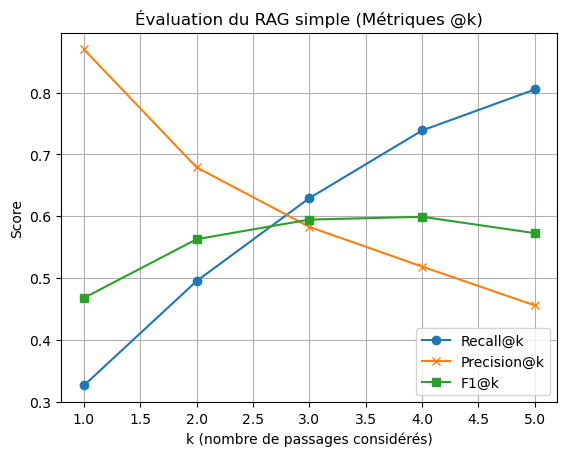

In [14]:
plt.plot(metrics_df['k'], metrics_df['Recall@k'], marker='o', label='Recall@k')
plt.plot(metrics_df['k'], metrics_df['Precision@k'], marker='x', label='Precision@k')
plt.plot(metrics_df['k'], metrics_df['F1@k'], marker='s', label='F1@k')
plt.xlabel('k (nombre de passages considérés)')
plt.ylabel('Score')
plt.title('Évaluation du RAG simple (Métriques @k)')
plt.legend()
plt.grid(True)
plt.savefig('evaluation_rag_simple.png', dpi=300, bbox_inches='tight')  
plt.show()